In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import xgboost as xgb
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)

The XGboost Tree Regression model was trained base on 
the 2018-01-02 to 2018-06-29 10min candle stick's data 
and its 123 technical indicator features.

In [2]:
#Load the Model
model = xgb.XGBRegressor()
model.load_model('xgbreg_EURUSD_10m_v7_buy.model')
scaler = joblib.load('xgbscaler_EURUSD_10m_v7_buy.pkl')

In [3]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Testing data is from 2018-07-05 to 2019-02-26.

If the price goes up 0.002 in the future first, y = 0 ,if goes down 0.002 first, y = 2

In [4]:
test = pd.read_csv('test/EURUSD_M10_0.002_.csv',index_col=0)
test = test[test['y']!=1]
y_test = test['y']
x_test = test.drop(['y','High','Low','Close','Open','Datetime'],axis = 1)
x_test = scaler.transform(x_test)

In [5]:
y_p = model.predict(x_test)

The regression model will pridict a value shows how possible the price will move. 

The larger the price may go higher.

The following chart is the distribution of the predicted values

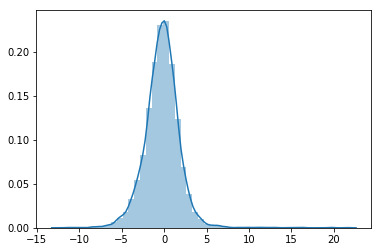

In [6]:
sns.distplot(y_p)

The strategy is set to if predicted value is higher than 3.7, the model will make a buy order,

which set the Take Profit is 0.002 higher than current Closing Price, and Stop Loss is 0.002 lower
than current Closing Price

In [7]:
buyline = 3.7
yps = []
for i in y_p:
    if i > buyline:
        t = 0
    else:
        t = 1
    yps.append(t)
yps = np.asarray(yps)

In [8]:
def trade_acc(cm,tpp,slp):
    tp = cm[0][0]+cm[2][2]
    sl = cm[0][1]+cm[0][2]+cm[2][1]+cm[2][0]
    tb_rate = cm[0][0] / (cm[0][0]+cm[0][1]+cm[0][2])
    print('Total buy orders: '+str(cm[0][0]+cm[0][2]))
    print('Win Rate of Buy %: '+str(tb_rate))
    print('total profit pips: '+str(tpp*tp-slp*sl))
    profit_factor = (cm[0][0]*tpp)/(cm[0][2]*slp)
    print('Profit Factor: '+str(profit_factor))

In [9]:
cm = confusion_matrix(yps,y_test)
trade_acc(cm,18.5,21.5)

Total buy orders: 275
Win Rate of Buy %: 0.7018181818181818
total profit pips: 1807.5
Profit Factor: 2.025241066364152


Including the spread the Broker may charge(averagely is 1.5 pips), we assume if the order take a profit, the balance will +180 and stop loss trigers will -215

The following is the Balance chart

In [10]:
chart = pd.DataFrame({'date':test['Datetime'],'r':y_test,'p':yps})
chart = chart.reset_index()
del chart['index']
revs = []
rev_int = 0
for i in chart.index:
    if chart['p'][i] ==0:
        if chart['r'][i] ==0:
            rev_int = rev_int+180
        else:
            rev_int = rev_int-215
    else:
        if chart['p'][i] ==2:
            if chart['r'][i] ==2:
                rev_int = rev_int+180
            else:
                rev_int = rev_int-215
        else:
            rev_int = rev_int
    revs.append(rev_int)
chart['balance'] = revs

In [11]:
trace = go.Scatter(name='Balance',
x = chart['date'],
y = chart['balance'],
mode='lines',                       
xaxis='x1',
yaxis='y1',
)

In [12]:
layout = go.Layout(
    yaxis=dict(title='Balance'),
    xaxis=dict(title='Date-Time'),
    title='Balance Change',
    showlegend = False)
fig = go.Figure(data=[trace], layout=layout)

pyo.iplot(fig)

Max Drawdown is a important factor to a trading strategy.

The following chart shows the Drawdown in the period.

In [13]:
mdds = []
for i in chart.index:
    dd_df = chart.loc[:i]
    dd = chart['balance'][i]-dd_df['balance'].max()
    mdds.append(dd)
chart['max_drawdown'] = mdds

In [14]:
trace2 = go.Scatter(name='Max Drawdown',
x = chart['date'],
y = chart['max_drawdown'],
mode='lines',                       
xaxis='x1',
yaxis='y1',
)

In [15]:
layout = go.Layout(
    yaxis=dict(title='Balance'),
    xaxis=dict(title='Date-Time'),
    title='Balance Change & Max Drawdown',
    showlegend = False)
fig = go.Figure(data=[trace,trace2], layout=layout)

pyo.iplot(fig)
print('max drawdown: '+str(chart['max_drawdown'].min()))
print('Total Profit: '+str(chart['balance'].iloc[-1]))

max drawdown: -2615
Total Profit: 17110


The following chart means to monitor the most recent 50 trades win rate(The moving average of 50 trades).

It is a way to check if the model depreciated?

In [16]:
trade_chart = chart[chart['p']!=1]
wins =[]
for i in trade_chart.index:
    if trade_chart['p'][i] ==trade_chart['r'][i]:
        a = 1
    else:
        a = 0
    wins.append(a)
trade_chart['win'] =wins 
trade_chart = trade_chart.reset_index()
del trade_chart['index']

mas = []
for i in trade_chart.index:

    a = trade_chart.loc[i-51:i]['win'].sum()/50

        
    mas.append(a)
trade_chart['MA'] = mas

    

In [17]:
trade_chart = trade_chart.loc[50:]

In [18]:
trace3 = go.Scatter(
x = trade_chart['date'],
y =  trade_chart['MA'],
mode='lines',                       
xaxis='x1',
yaxis='y1',)

In [19]:
layout = go.Layout(
    yaxis=dict(title='Win Rate'),
    xaxis=dict(title='Date-Time'),
    title='Moving Average of Recent 50 trades Win Rate',
    showlegend = False)
fig = go.Figure(data=[trace3], layout=layout)

pyo.iplot(fig)